In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader
import yaml

/u/kazumak2/.conda/envs/pytorch-env/lib/python3.9/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [8]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import SequentialDeepONetDataset
from helper import convert2dim, compute_metrics_region, plot_field_region, fit, load_model_experiment

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
input_data = np.load('data/neutron_data_22yrs.npy')
trunk = np.load('data/grid_points.npy')
target = np.load('data/dose_array.npy')

print("Input data shape:", input_data.shape)
print("Trunk shape:", trunk.shape)
print("Target shape:", target.shape)

Input data shape: (8400, 12)
Trunk shape: (65341, 2)
Target shape: (8400, 65341)


In [23]:
trunk[:, 0] = (trunk[:, 0] - np.min(trunk[:, 0])) / (np.max(trunk[:, 0]) - np.min(trunk[:, 0]))
trunk[:, 1] = (trunk[:, 1] - np.min(trunk[:, 1])) / (np.max(trunk[:, 1]) - np.min(trunk[:, 1]))

In [162]:
from forecasting_analysis import create_windows_forecasting_with_index

dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = 30, 0
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_data, target, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7641, 30, 12]) torch.Size([7641, 65341])
Validation set: torch.Size([365, 30, 12]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 12]) torch.Size([365, 65341])


In [163]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_input.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Fit on ALL training pixels (flattened)
scaler_target = MinMaxScaler()

# Transform sets
y_train_scaled = scaler_target.fit_transform(y_train)[..., np.newaxis]
y_val_scaled   = scaler_target.transform(y_val)[..., np.newaxis]
y_test_scaled  = scaler_target.transform(y_test)[..., np.newaxis]

# create datasets
train_dataset = SequentialDeepONetDataset(X_train_scaled, trunk, y_train_scaled)
val_dataset   = SequentialDeepONetDataset(X_val_scaled,   trunk, y_val_scaled)
test_dataset  = SequentialDeepONetDataset(X_test_scaled,  trunk, y_test_scaled)

# create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [164]:
model = load_model_experiment('analysis/baseline/single_branch/lstm_window_30.pth')
model = model.to(device)

Loaded model from analysis/baseline/single_branch/lstm_window_30.pth


In [165]:
preds, targets = fit(model, test_loader, device, scaler_target)

In [166]:
# ---- load YAML (list of dicts) ----
with open("analysis/forecasting/yaml/city_columns.yaml", "r", encoding="utf-8") as f:
    cities = yaml.safe_load(f)

# ---- unpack fields ----
names = [c["name"] for c in cities]
cols  = np.array([int(c["col"])   for c in cities], dtype=np.int64)
lat_i = np.array([int(c["lat_i"]) for c in cities], dtype=np.int16)
lon_i = np.array([int(c["lon_i"]) for c in cities], dtype=np.int16)

print("Names:", names)
print("Cols:", cols.shape, "Lat/Lon:", lat_i.shape, lon_i.shape)

Names: ['New_York', 'San_Francisco', 'São_Paulo', 'London', 'Helsinki', 'Cairo', 'Johannesburg', 'Riyadh', 'Delhi', 'Tokyo', 'Jakarta', 'Sydney']
Cols: (12,) Lat/Lon: (12,) (12,)


New_York (col 19317): Spearman ρ = 0.9991
San_Francisco (col 10626): Spearman ρ = 0.9991
São_Paulo (col 24139): Spearman ρ = 0.9991
London (col 32722): Spearman ρ = 0.9991
Helsinki (col 37255): Spearman ρ = 0.9991
Cairo (col 38311): Spearman ρ = 0.9991
Johannesburg (col 37712): Spearman ρ = 0.9991
Riyadh (col 41202): Spearman ρ = 0.9990
Delhi (col 46636): Spearman ρ = 0.9991
Tokyo (col 58046): Spearman ρ = 0.9991
Jakarta (col 52031): Spearman ρ = 0.9990
Sydney (col 59967): Spearman ρ = 0.9991


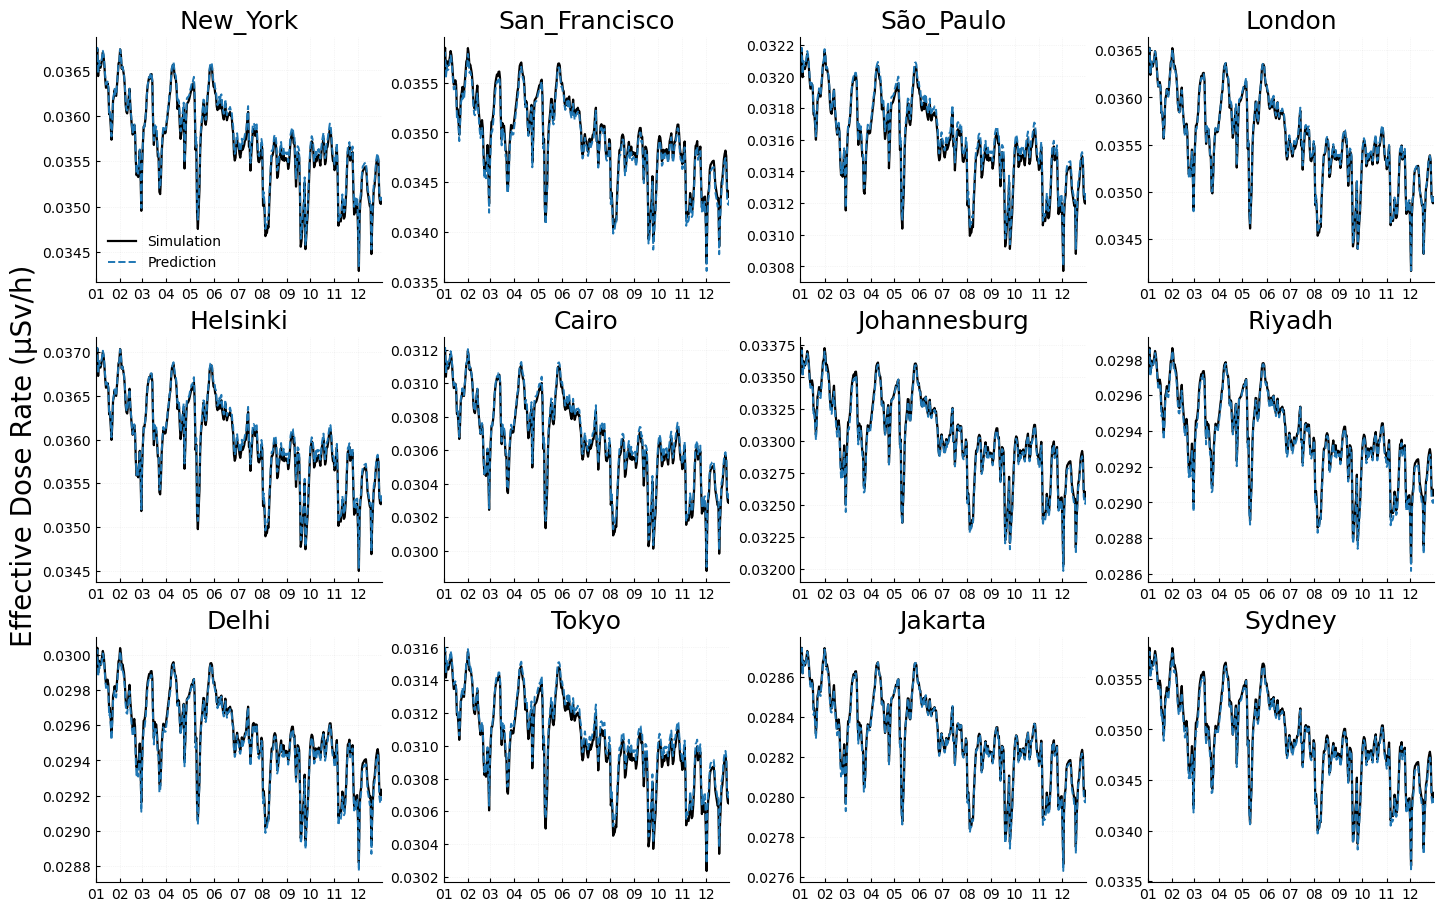

In [167]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import spearmanr

# ============================================================
# CONFIGURATION
# ============================================================

USE_GRAYSCALE = False     # True for print-safe version
LINE_W_SIM = 1.6          # Simulation line width
LINE_W_PRED = 1.4         # Prediction line width

COLS = {
    "black": "#000000",
    "blue":  "#0072B2",
}

plt.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 16,
    "legend.fontsize": 10,
    "savefig.dpi": 300,
})

# ============================================================
# FIGURE SETUP
# ============================================================

fig, ax = plt.subplots(3, 4, figsize=(14, 9), constrained_layout=True)

month_locator = mdates.MonthLocator(bymonthday=1)
month_fmt     = mdates.DateFormatter('%m')  # "01", "02", ...

# ============================================================
# PLOTTING LOOP
# ============================================================

for i in range(len(names)):
    city_name = names[i]
    j         = cols[i]
    pred      = preds[:, j]
    targ      = targets[:, j]
    dates     = tgt_dates[test_mask]

    # --- Spearman correlation ---
    rho, _ = spearmanr(pred, targ)
    print(f"{city_name} (col {j}): Spearman ρ = {rho:.4f}")

    axi = ax.flat[i]

    # ===== Journal-safe color & linestyle selection =====
    if USE_GRAYSCALE:
        sim_color  = COLS["black"]
        pred_color = "#1f77b4"
        sim_ls  = "-"
        pred_ls = "--"
    else:
        sim_color  = COLS["black"]        # Simulation
        pred_color = "#1f77b4"            # Prediction (from default matplotlib palette)
        sim_ls  = "-"
        pred_ls = "--"

    # ============================================================
    # PLOT
    # ============================================================
    axi.plot(
        dates, targ,
        color=sim_color,
        linestyle=sim_ls,
        linewidth=LINE_W_SIM,
        label="Simulation"
    )
    axi.plot(
        dates, pred,
        color=pred_color,
        linestyle=pred_ls,
        linewidth=LINE_W_PRED,
        label="Prediction"
    )

    # ============================================================
    # COSMETICS
    # ============================================================
    axi.set_title(city_name, fontsize=18)
    axi.set_xlim(dates[0], dates[-1])
    axi.xaxis.set_major_locator(month_locator)
    axi.xaxis.set_major_formatter(month_fmt)
    axi.xaxis.set_minor_locator(mticker.NullLocator())
    axi.grid(alpha=0.25, linestyle=":", linewidth=0.5)

    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.tick_params(axis='both', direction='in', length=3, width=0.8, labelsize=10)

# ============================================================
# GLOBAL LABELS
# ============================================================

ax[0, 0].legend(loc="lower left", frameon=False)
fig.text(-0.02, 0.5, "Effective Dose Rate (µSv/h)", va="center",
         rotation="vertical", fontsize=20)

plt.savefig("analysis/baseline/figures/loc_prediction_results.png", bbox_inches="tight", dpi=300)
plt.show()


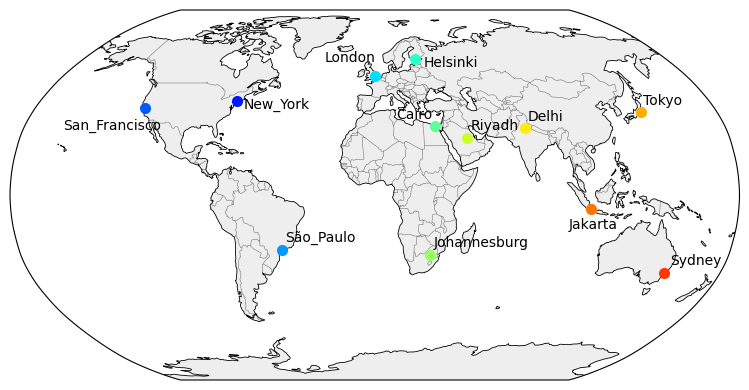

In [168]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# ============================================================
# If lat_i, lon_i in YAML are TRUE geographic coordinates:
#    - simply convert them to float
# ============================================================

lats = np.array(lat_i, dtype=float)
lons = np.array(lon_i, dtype=float)

# If instead lat_i/lon_i are GRID indices and you want to convert:
# Example (modify according to your dataset)
# lats = lat_vals[lat_i]
# lons = lon_vals[lon_i]

# ============================================================
# FIGURE
# ============================================================

fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.Robinson())

ax.set_global()
ax.coastlines(linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor="#eeeeee")
#ax.add_feature(cfeature.OCEAN, facecolor="#d9e6f2")

# ============================================================
# PLOT CITIES
# ============================================================

# good contrasting color palette
colors = plt.cm.jet(np.linspace(0.15, 0.85, len(names)))

for i, name in enumerate(names):
    lat = lats[i]
    lon = lons[i]

    ax.plot(
        lon, lat,
        marker="o",
        markersize=7,
        color=colors[i],
        transform=ccrs.PlateCarree()
    )

    # Label with small offset
    if name == "San_Francisco":
        ax.text(
            lon - 40, lat - 5,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='top'
        )
    elif name == "New_York":
        ax.text(
            lon + 5, lat -5,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    elif name == "London":
        ax.text(
            lon -30, lat + 5,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    elif name == "Helsinki":
        ax.text(
            lon + 4, lat - 5,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    elif name == "Cairo":
        ax.text(
            lon - 20, lat + 2,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    elif name == "Jakarta":
        ax.text(
            lon - 10, lat - 10,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    else:
        ax.text(
            lon + 2, lat + 2,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )

#plt.title("City Locations Used for Forecasting Dataset", fontsize=12)
plt.tight_layout()
plt.savefig("analysis/baseline/figures/loc_city_locations.png", bbox_inches="tight", dpi=300)
plt.show()


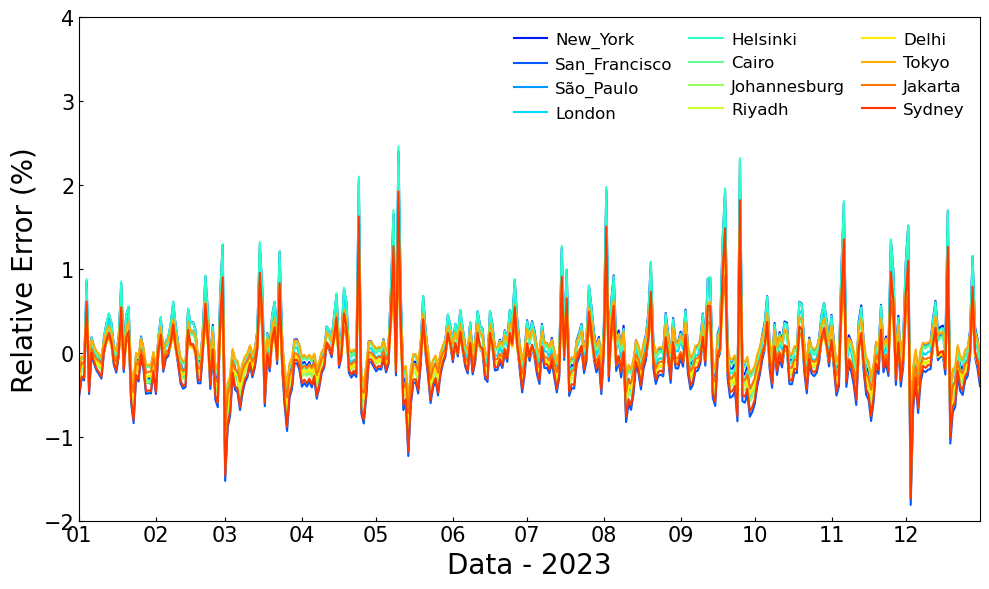

In [161]:
pred_city = preds[:, cols, :]
targets_city = targets[:, cols, :]

# pred_city.shape -> (365, 12, 1)
# compute relative error per city
rel_errors = (pred_city.squeeze(-1) - targets_city.squeeze(-1)) / np.maximum(targets_city.squeeze(-1), 1e-6) * 100
dates = tgt_dates[test_mask]
fig, ax = plt.subplots(figsize=(10, 6))
for i, name in enumerate(names):
    ax.plot(dates,
        rel_errors[:, i],
        label=name,
        color=colors[i]
    )
    
ax.legend(ncol=3, fontsize=12, frameon=False,
          columnspacing=1.0, handletextpad=0.5, handlelength=2.0, loc='upper right')
ax.set_xlim(dates[0], dates[-1])
ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(month_fmt)
ax.set_ylim(-2, 4)

ax.set_xlabel("Data - 2023", fontsize=20)
ax.set_ylabel("Relative Error (%)", fontsize=20)

# tick label size
ax.tick_params(axis='both', direction='in', length=3, width=0.8, labelsize=15)
plt.tight_layout()
plt.savefig("analysis/baseline/figures/loc_relative_errors.png", bbox_inches="tight", dpi=300)
plt.show()